# 1.  Import relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf

import warnings
warnings.filterwarnings('ignore')

# 2. Import historical stock price data using YFINANCE API

In [2]:
import yfinance as yf

stock = yf.Ticker('ADANIPORTS.NS')
stock = stock.history(period='1d',start='2008-01-01', end = '2022-04-22')

In [3]:
stock.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-01-01,236.961943,244.372779,234.127295,240.269028,2456740,0.0,0.0
2008-01-02,242.751622,245.299101,235.294466,242.232864,3519075,0.0,0.0
2008-01-03,241.779028,243.576162,233.654878,236.369110,2525290,0.0,0.0
2008-01-04,236.924861,239.889198,228.439448,229.801193,2753975,0.0,0.0
2008-01-07,229.736357,236.943408,225.104575,227.374146,3154815,0.0,0.0
2008-01-08,229.736355,232.515424,219.546436,223.214813,2652495,0.0,0.0
2008-01-09,222.325501,224.178214,213.247207,218.666397,3137535,0.0,0.0
2008-01-10,219.546449,222.288470,205.651104,207.790985,2194030,0.0,0.0
2008-01-11,208.986011,209.356548,196.943377,201.176819,3084690,0.0,0.0


In [4]:
stock.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

We can notice that dates are not consecutive. The missing dates correspond to non trading on holidays/weekends.

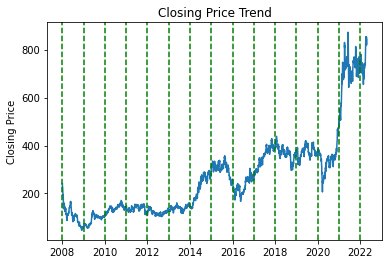

In [5]:
plt.plot(stock["Close"])
plt.title("Closing Price Trend")
plt.ylabel("Closing Price")
for year in range(2008,2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), linestyle='--',color='g')
plt.show()

# 3. Preparing data for analysis

In [6]:
stock = stock.asfreq(pd.infer_freq(stock.index))

In [7]:
stock.index

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-15',
               '2022-04-16', '2022-04-17', '2022-04-18', '2022-04-19',
               '2022-04-20', '2022-04-21'],
              dtype='datetime64[ns]', name='Date', length=5225, freq='D')

In [8]:
stock.isnull().sum()

Open            1701
High            1701
Low             1701
Close           1701
Volume          1701
Dividends       1701
Stock Splits    1701
dtype: int64

In [9]:
stock = stock.fillna(method='bfill')
# we can fill in previous day values when data is missing (these are days of non trading so it makes sense to use previous day value)

In [10]:
# We will use monthly consolidated data to make the analysis easier
stock = pd.DataFrame(data =stock.resample(rule='MS').mean()["Close"])

In [11]:
stock_decomposed = seasonal_decompose(stock["Close"], model='multiplicative')

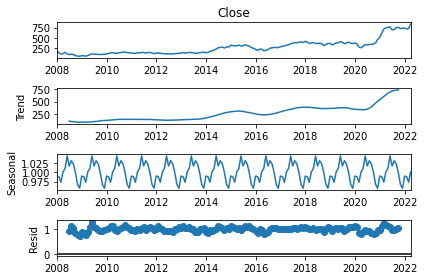

In [12]:
stock_decomposed.plot()
plt.show()

As we can see from the plots, there is clear trend & seasonality in this dataset. This indicates that the data is non-stationary. We can also confirm this with the Augmented Dickey Fuller Test ( Stationary if p < 0.05 or Z < Crtitical Z)

# 4. Tests to determine stationary properties of dataset

In [13]:
if adfuller(stock["Close"])[1] < 0.05:
    print("The data is Stationary")
else:
    print("The data is not Stationary.")

The data is not Stationary.


To plot ACF(Autocorrelation Factor) and PACF(Partial Autocorrection Factor) plots, we require the data to be stationary. In order to make the data stationary we can perform differencing and check with adfuller test once again.

In [14]:
# Current value differenced with previous value
stock["First_Diff"] = stock["Close"] - stock["Close"].shift(1)
stock.fillna(0,inplace=True)

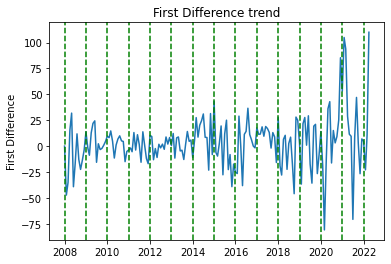

In [15]:
plt.plot(stock["First_Diff"])
plt.ylabel("First Difference")
plt.title("First Difference trend")
for year in range(2008,2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), linestyle='--',color='g')
plt.show()

In [16]:
if adfuller(stock["First_Diff"])[1] < 0.05:
    print("The data is Stationary.")
else:
    print("The data is not Stationary.")

The data is Stationary.


# 5. Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots

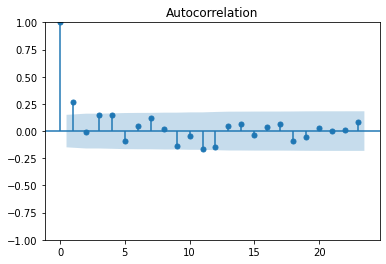

In [17]:
# We can now plot ACF AND PACF to decide order of the terms in the model;
plot_acf(stock["First_Diff"])
plt.show()

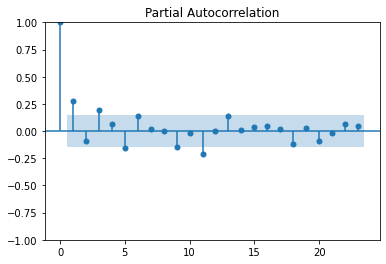

In [18]:
plot_pacf(stock["First_Diff"])
plt.show()

Analysis of ACF, PACF Plots : 

1. ACF plots shows significance at lags 1 and near 12; (q : 1, Q = 1)
2. PACF shows significant lags at 1, 3, 12; (p : 3, P : 1)
3. Differencing of one order made data stationary, and another order of differencing to remove seasonality; (d : 1, D : 1)


Let us build a model using these parameters and check their validity;

In [19]:
from datetime import datetime, timedelta

In [20]:
# Let us create train and test data (we will use 2015 - 2020 as train and 2021-present to test )

train_end = datetime(2020,1,1)
test_end = datetime(2022,4,1)


train_data = stock[:train_end]
test_data = stock[train_end + timedelta(1) : test_end]

# 6. Building the model

To build the model we can use two apporaches : 

1. Make interpretations on acf and pacf plots to determine order of terms (pdq and PDQm) and use a Seasonal ARIMA Model.
2. Use an Auto ARIMA Model to build multiple models and choose the one with the best AIC score.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [22]:
import pmdarima as pm

In [23]:
automodel = pm.auto_arima(train_data["Close"],start_p=1, start_q=1,
                      test='adf',       
                      max_p=5, max_q=5, 
                      m=12,             
                      d=None,           
                      seasonal=True,  
                      start_P=0, 
                      D=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1495.481, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1209.858, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1510.017, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1247.143, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1192.571, Time=0.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1444.411, Time=0.77 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1192.918, Time=1.12 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1192.295, Time=1.32 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1210.612, Time=0.48 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=i

In [24]:
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  145
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -591.776
Date:                            Sun, 24 Apr 2022   AIC                           1191.552
Time:                                    13:23:41   BIC                           1203.114
Sample:                                         0   HQIC                          1196.251
                                            - 145                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9655      0.020     48.188      0.000       0.926       1.005
ar.S.L12      -0.7900      0.092     -8.603      0.000      -0.970      -0.610
ar.S.L24      -0.4188      0.088     -4.753      0.000      -0.591      -0.246
sigma2       395.1336     48.552      8.138      0.000     299.973     490.295
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.69   Prob(JB):                         0.22
Heteroskedasticity (H):               1.54   Skew:                            -0.35
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Instead of predicting 'n' time periods into the future, we will utilize a rolling forecast origin to predict only one time period into the future. Normally when we predict 'n' time periods into the future, as we move further away from our courrent time the uncertainty in our prediction increases.To prevent that we use the Rolling Forecast Method. 

In [25]:
# ROLLING FORECAST PREDICTION

rolling_predictions_a = pd.Series()
rolling_predictions_b = pd.Series()


for date in test_data.index:
    train = stock[ : date - timedelta(1)]["Close"]
    
    
    # Model parameters obtained from auto arima.
    model_a = SARIMAX(train, order = (1,0,0), seasonal_order = (2,1,0,12)) 
    
    # Model with hpothesized parameters obtained from ACF,PACF plots.
    model_b = SARIMAX(train, order = (3,1,1), seasonal_order = (1,1,1,12))
    
    
    modela_fit = model_a.fit()
    pred_a = modela_fit.predict(date)
    rolling_predictions_a.loc[date] = pred_a.loc[date]
    
    modelb_fit = model_b.fit()
    pred_b = modelb_fit.predict(date)
    rolling_predictions_b.loc[date] = pred_b.loc[date]
    


In [26]:
residuals_a = test_data["Close"] - rolling_predictions_a
residuals_b = test_data["Close"] - rolling_predictions_b

# 7. Model Evaluation

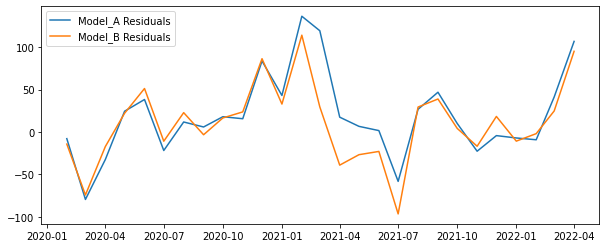

In [27]:
plt.figure(figsize=(10,4))
plt.plot(residuals_a)
plt.plot(residuals_b)
plt.legend(('Model_A Residuals',"Model_B Residuals"))
plt.show()

Time series data is essentially made up of two componenents : 
signal + white noise (random events that infulence the time series values for ex.stock prices influenced by government laws, leadership of company etc).While we can model the signal, the white noise can not be modelled accurately. When we build models, we are actually trying to capture the white noise throught the residuals (predicted val - actual val). If our model is as close to properties of whute noise (constant mean of 0, constant variance and std deviation). It is doing a fairly decent job. The model we built above has a mean close to zero but variance is quite high.

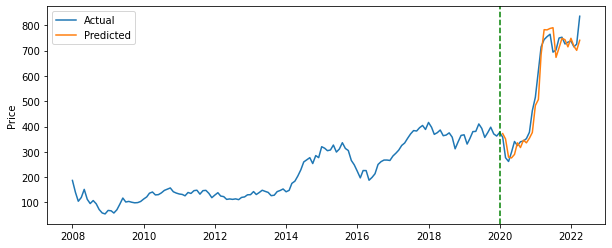

In [30]:
plt.figure(figsize=(10,4))
plt.plot(stock["Close"])
plt.plot(rolling_predictions_b)
plt.legend(('Actual',"Predicted"))
for year in range(2020,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), linestyle='--',color='g')
plt.ylabel("Price")
plt.show()

In [31]:
#Using mean absolute percent error as a metric

print("Auto ARIMA Model Accuracy (%) : ", 100 -  np.mean(abs(residuals_a*100/test_data["Close"])))
print("SARIMA Model Accuracy (%) :",100 -  np.mean(abs(residuals_b*100/test_data["Close"])))

Auto ARIMA Model Accuracy (%) :  92.72987202093887
SARIMA Model Accuracy (%) : 93.11160002974542


# 8. Conclusion

We have used a simple approach to model stock price data. However in reality, volatility of stock data is also another important parameter to keep in mind when attempting to model it. GARCH (Generalized AutoRegressive Conditional Heterdoskedacity) model is one such model that takes into account both the value and volatility (variance) of previous time perod data in order to model it.

-----------------------